# Clothing Segmentation using UNET

In [1]:
"""
@authors: berfin-canbolant, ulas-kaplan
"""

import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import imageio

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# The paths for the images and masks to be separated for training and testing
IMAGE_PATH = r"Datasets\image"
GT_CLOTH_MASK_PATH = r"Datasets\gt_cloth_warped_mask"


In [3]:
# 30% of the masks and images will be randomly selected and allocated for testing

percentage = 0.30  
ids = []
for root, dirs, files in os.walk(IMAGE_PATH):
    for file in files:
        if file.lower().endswith('.jpg'):
            file_id = os.path.splitext(file)[0]
            ids.append(file_id)

num_ids = len(ids)
num_test_ids = int(num_ids * percentage)

test_ids = random.sample(ids, num_test_ids)
train_ids = list(set(ids) - set(test_ids))

# Two NumPy arrays will be created for the training set: one for the masks and one for the images

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# Resizing training images and masks

In [4]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    img_path = os.path.join(IMAGE_PATH, id_ + '.jpg')
    img = imageio.imread(img_path)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    mask_path = os.path.join(GT_CLOTH_MASK_PATH, id_ + '.jpg')
    mask = imageio.imread(mask_path)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)  
    Y_train[n] = mask

  0%|          | 0/8153 [00:00<?, ?it/s]C:\Users\ulask\AppData\Local\Temp\ipykernel_12444\3088294930.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)[:, :, :IMG_CHANNELS]
C:\Users\ulask\AppData\Local\Temp\ipykernel_12444\3088294930.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)
100%|██████████| 8153/8153 [12:39<00:00, 10.73it/s]


# Resizing test images

In [5]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img_path = os.path.join(IMAGE_PATH, id_ + '.jpg')
    img = imageio.imread(img_path)[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing test images


  0%|          | 0/3494 [00:00<?, ?it/s]C:\Users\ulask\AppData\Local\Temp\ipykernel_12444\1517320226.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)[:, :, :IMG_CHANNELS]
100%|██████████| 3494/3494 [06:10<00:00,  9.42it/s]


# UNET Architecture

In [7]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
                                                                                              

In [21]:
model_save_path = r'model_save_path.keras'
log_dir = r'logs'



checkpointer = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]




# Model Fitting

In [22]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
459/459 [==============================] - 400s 861ms/step - loss: 0.1793 - accuracy: 0.9261 - val_loss: 0.1104 - val_accuracy: 0.9583
Epoch 2/25
459/459 [==============================] - 344s 749ms/step - loss: 0.0906 - accuracy: 0.9655 - val_loss: 0.0720 - val_accuracy: 0.9724
Epoch 3/25
459/459 [==============================] - 353s 768ms/step - loss: 0.0696 - accuracy: 0.9737 - val_loss: 0.0574 - val_accuracy: 0.9785
Epoch 4/25
459/459 [==============================] - 369s 805ms/step - loss: 0.0624 - accuracy: 0.9762 - val_loss: 0.0582 - val_accuracy: 0.9778
Epoch 5/25
459/459 [==============================] - 357s 778ms/step - loss: 0.0576 - accuracy: 0.9782 - val_loss: 0.0537 - val_accuracy: 0.9802
Epoch 6/25
459/459 [==============================] - 358s 780ms/step - loss: 0.0508 - accuracy: 0.9807 - val_loss: 0.0501 - val_accuracy: 0.9813
Epoch 7/25
459/459 [==============================] - 401s 873ms/step - loss: 0.0480 - accuracy: 0.9817 - val_loss: 0.0517 -

In [23]:
preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


110/110 [==============================] - 29s 259ms/step


# Viewing Results

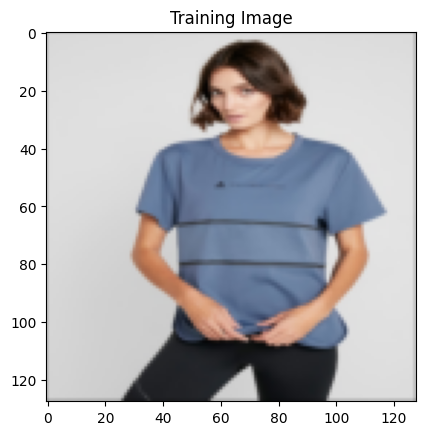

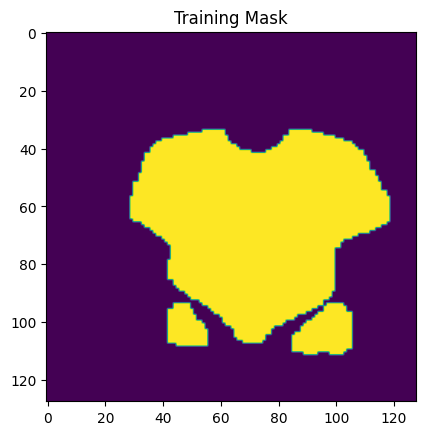

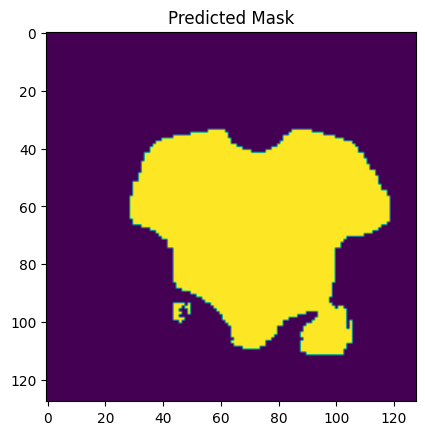

In [36]:
ix = random.randint(0, len(preds_train_t) - 1)
plt.imshow(X_train[ix])
plt.title('Training Image')
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('Training Mask')
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.title('Predicted Mask')
plt.show()


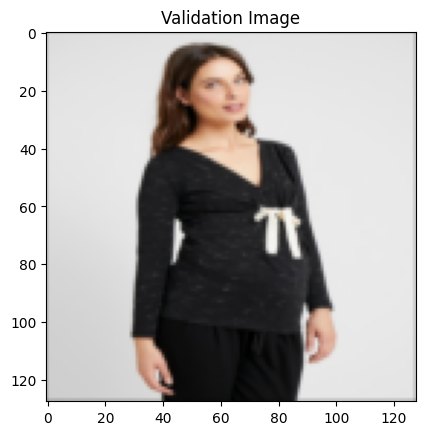

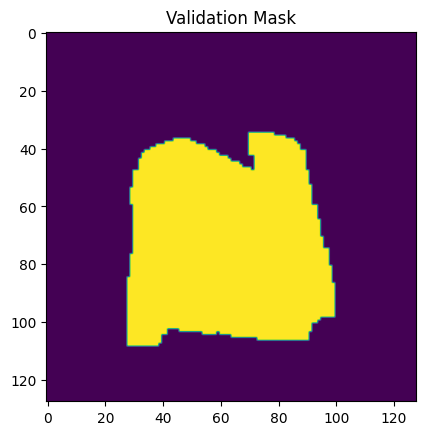

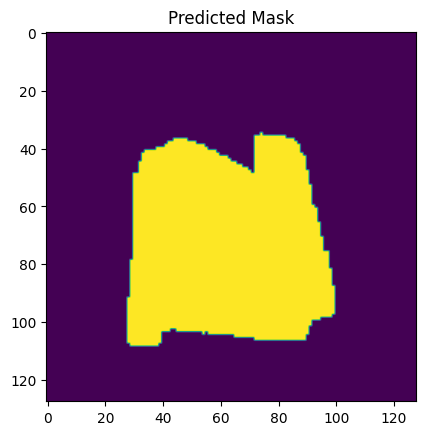

In [37]:
ix = random.randint(0, len(preds_val_t) - 1)
plt.imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
plt.title('Validation Image')
plt.show()
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0] * 0.9):][ix]))
plt.title('Validation Mask')
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.title('Predicted Mask')
plt.show()


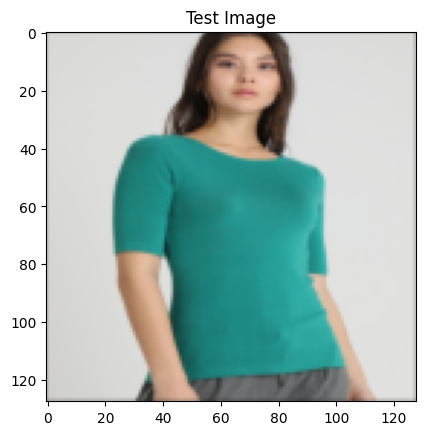

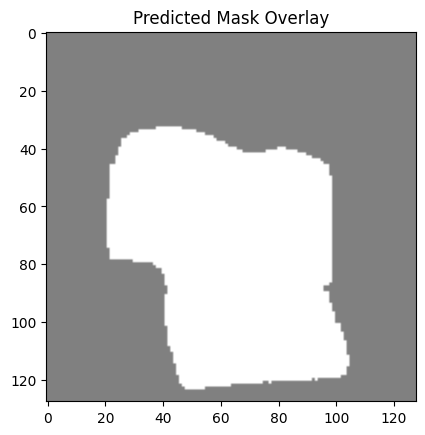

In [38]:
ix = random.randint(0, len(preds_test_t) - 1)
plt.imshow(X_test[ix])
plt.title('Test Image')
plt.show()
plt.imshow(np.squeeze(preds_test_t[ix]), cmap='gray', alpha=0.5)
plt.title('Predicted Mask Overlay')
plt.show()

In [46]:
"""
Overlay a mask onto an image.
Args:
image (numpy array): The original image.
mask (numpy array): The mask to overlay on the image.
alpha (float): Transparency level of the mask overlay.
Returns:
result (numpy array): The image with mask overlay.
"""
def overlay_mask_on_image(image, mask, alpha=1):
    
    # Reshape the mask to grayscale
    mask = np.squeeze(mask)
    mask_gray = np.zeros_like(image, dtype=np.uint8)
    mask_gray[mask > 0] = [128, 128, 128]  

    # Overlay the mask on the image
    result = image.copy()
    result[mask > 0] = (result[mask > 0] * (1 - alpha) + mask_gray[mask > 0] * alpha).astype(np.uint8)
    return result

In [47]:
ix = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[ix]
test_mask = preds_test_t[ix]

In [48]:
overlay_image = overlay_mask_on_image(test_image, test_mask)

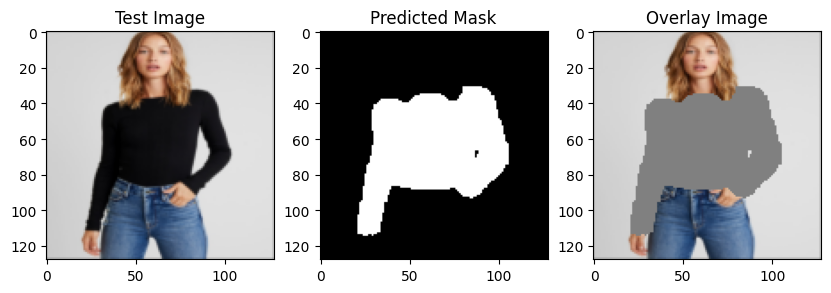

In [49]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

In [53]:
ix = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[ix]
test_mask = preds_test_t[ix]

In [54]:
overlay_image = overlay_mask_on_image(test_image, test_mask)

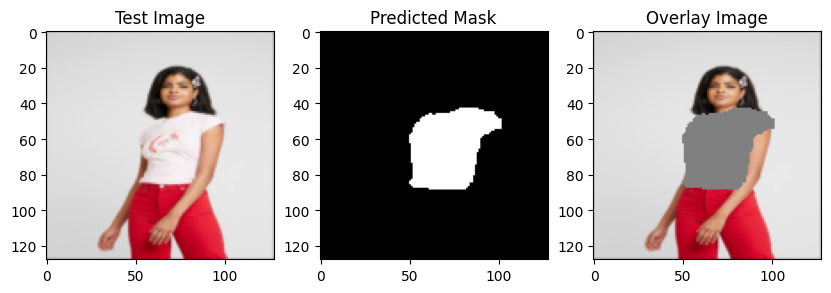

In [55]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

In [56]:
ix = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[ix]
test_mask = preds_test_t[ix]

In [57]:
overlay_image = overlay_mask_on_image(test_image, test_mask)

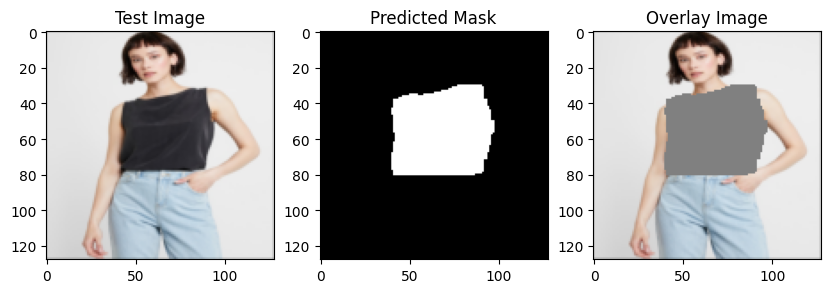

In [58]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()